# Название проекта:
HR-аналитика

# Цель:
Разработать модель, которая позволит быстрее и точнее отвечать на вопросы бизнеса, а именно предсказывать уровень удовлетворённости сотрудника работой и отток сотрудников

# Исходные данные:
5 датасетов: 2 тренировочные выбыборки, 1 с входными признаками тестовых выборкок, 2 с целевым признаком тестовых выборкок. В датасетах предаставлена рабочая информация о сотрудниках.

# План:
- Задача 1: предсказание уровня удовлетворённости сотрудника
  - Загрузка данных
  - Предобработка данных
  - Исследовательский анализ данных
  - Подготовка данных
  - Обучение моделей
  - Оформление выводов
- Задача 2: предсказание увольнения сотрудника из компании
  - Загрузка данных
  - Предобработка данных
  - Исследовательский анализ данных
  - Добавление нового входного признака
  - Подготовка данных
  - Обучение модели
  - Выводы
- Общий вывод

## Задача 1: Предсказание уровня удовлетворённости сотрудника

### Шаг 1. Загрузка данных

In [1]:
!pip3 install -q phik
!pip install -q shap 
!pip install -q ydata-profiling
!pip install -q optuna 
!pip install -q optuna-integration

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.0.17 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 2.8.2 which is incompatible.
spacy 3.2.0 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 2.8.2 which is incompatible.


In [2]:
pip install -q --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import plotly.offline as pyo
import plotly.graph_objs as go
import warnings
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix, make_scorer
from sklearn.pipeline import Pipeline
import shap
import phik
from phik import resources, report
from ydata_profiling import ProfileReport
import pandas_profiling
import optuna
from optuna import distributions

/tmp/ipykernel_48/4249481667.py:25: DeprecationWarning:

`import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.



In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [5]:
warnings.filterwarnings('ignore')

In [6]:
train_sat = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
test_sat = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

In [7]:
train_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [8]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [9]:
test_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [10]:
train_sat.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [11]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [12]:
test_sat.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Данные соотвествуют описанию задачи. Размер тренировочной выборки - 4000, тестовой- 2000. Все названия столбоцов корректны и соответсвуют змеиному регистру.

In [13]:
#Автоматический разведочной анализ данных
profile = ProfileReport(train_sat, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Шаг 2. Предобработка данных

In [14]:
#Преобразуем тип данных в наиболее подходящий
#train_sat['last_year_violations'] = train_sat['last_year_violations'].astype('bool')

In [15]:
#Переведем столбец id в индекс
train_sat = train_sat.set_index('id')
test_features = test_features.set_index('id')
test_sat = test_sat.set_index('id')


In [16]:
#Проверим наличие пропусков в данных
print(f'Пропусков в train_sat: {train_sat.isnull().sum()}')
print()
print(f'Пропусков в test_features: {test_features.isnull().sum()}')
print()
print(f'Пропусков в test_sat: {test_sat.isnull().sum()}')


Пропусков в train_sat: dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Пропусков в test_features: dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Пропусков в test_sat: job_satisfaction_rate    0
dtype: int64


Пропуски заполним в пайплайне

In [17]:
#Проверим наличие явных дубликатов
print(f'Явных дубликатов в train_sat: {train_sat.duplicated().sum()}')
print(f'Явных дубликатов в test_features: {test_features.duplicated().sum()}')
print(f'Явных дубликатов в test_sat: {test_sat.duplicated().sum()}')

Явных дубликатов в train_sat: 245
Явных дубликатов в test_features: 557
Явных дубликатов в test_sat: 1902


Удалим явыне дубликаты в тренировочных данных </b></span>

In [18]:
train_sat = train_sat.drop_duplicates()

In [19]:
train_sat.shape

(3755, 9)

Проверим наличие неявных дубликатов

In [20]:
#Создадим список категориальных признаков
cat_columns = train_sat.select_dtypes(include='object').columns.tolist()
cat_columns

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

In [21]:
#Уникальные значения категориальных признаков тренировочной выборки
for col in cat_columns:
    print(f'Уникальные значения {col}: {train_sat[col].unique()}')
    

Уникальные значения dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значения level: ['junior' 'middle' 'sinior' nan]
Уникальные значения workload: ['medium' 'high' 'low']
Уникальные значения last_year_promo: ['no' 'yes']
Уникальные значения last_year_violations: ['no' 'yes']


In [22]:
#Уникальные значения категориальных признаков тестовой выборки
for col in cat_columns:
    print(f'Уникальные значения {col}: {test_features[col].unique()}')
    

Уникальные значения dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения level: ['junior' 'middle' 'sinior' nan]
Уникальные значения workload: ['medium' 'low' 'high' ' ']
Уникальные значения last_year_promo: ['no' 'yes']
Уникальные значения last_year_violations: ['no' 'yes']


Все данные находятся в нужных типах, были исследованы пропуски, а также изучены явные и неявные дубликаты. Данные готовы для дальнейшей обработки.

### Шаг 3. Исследовательский анализ данных

In [23]:
train_sat.describe(include='all')

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
count,3749,3751,3755,3755.000000,3755,3755,3755.000000,3755.000000,3755.000000
unique,5,3,3,NaN,2,2,NaN,NaN,NaN
top,sales,junior,medium,NaN,no,no,NaN,NaN,NaN
freq,1374,1699,1908,NaN,3635,3202,NaN,NaN,NaN
mean,NaN,NaN,NaN,3.817044,NaN,NaN,3.463648,34457.416778,0.532554
std,NaN,NaN,NaN,2.557142,NaN,NaN,1.026265,15050.643870,0.226393
min,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,12000.000000,0.030000
25%,NaN,NaN,NaN,2.000000,NaN,NaN,3.000000,22800.000000,0.350000
50%,NaN,NaN,NaN,3.000000,NaN,NaN,4.000000,31200.000000,0.550000
75%,NaN,NaN,NaN,6.000000,NaN,NaN,4.000000,44400.000000,0.710000


- dept: самый популярный отдел - отдел продаж
- level: больше всего в компании сотрудников с уровенем занимаемой должности - junior
- workload: в большинстве случаев загруженность средняя
- employment_years: среднее время работы сотрудника в компании - 3.7 года, медиана - 3 года. Максимальный стаж работы - 10 лет
- last_year_promo: в большинстве случаев сотрудника не повышали за последний год
- last_year_violations: в основном за последний год сотрудники не нарушали трудовой договор
- supervisor_evaluation: в среднем качество работы сотрудника оценивается - 3.5, медиана - 4
- salary: средняя заработная плата - 33927, медиана - 30000
- job_satisfaction_rate: средний уровень удовлетворенности работой - 0.53, медиана - 0.56

In [24]:
#Создадим список с количественными признаками
quan_columns = train_sat.select_dtypes('int').columns.tolist()
quan_columns

['employment_years', 'supervisor_evaluation', 'salary']

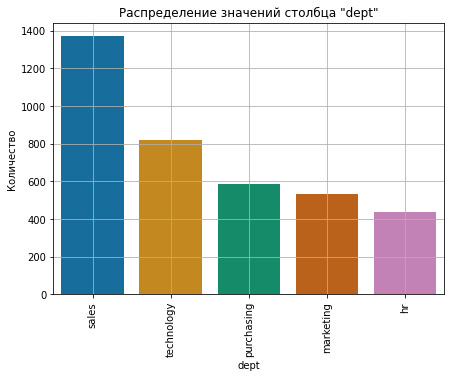

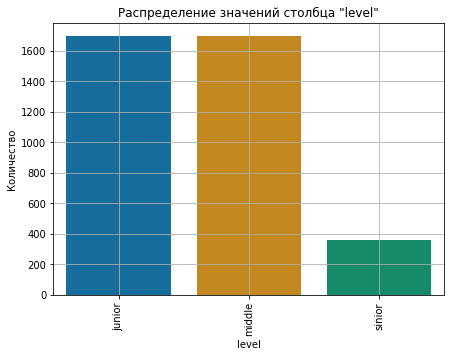

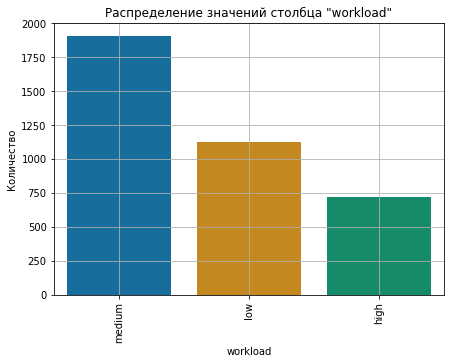

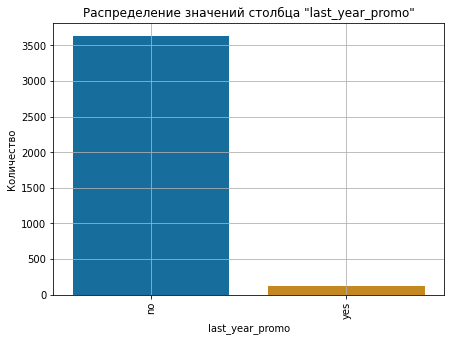

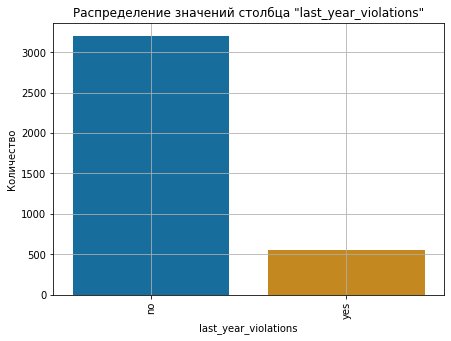

In [25]:
%matplotlib inline
#Построим распредленеия качественных признаков для train_sat
for col in cat_columns:
    fig, ax = plt.subplots(figsize=(7,5))
    value_counts = train_sat[col].value_counts()
    sns.countplot(x=col, data=train_sat, palette='colorblind', order=value_counts.index)
    #plt.xticks(rotation=90)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90) 
    ax.set_xlabel(col)
    ax.set_ylabel('Количество')
    ax.set_title(f'Распределение значений столбца "{col}"')
    ax.grid(True)

Присутсвует явный дисбаланс классов в last_year_promo и last_year_violations, что не удивительно, ведь действительно повышают или штрафуют только малую часть сотрудников. Также преобладает средняя нагрузка сотрудников против маленькой или большой. Больше всего сотудников в отделе продаж, а меньше всего в отделе hr.

In [26]:
def scatter_diagrams(data, x, y, cat):
    ''' Диаграмма рассеяния количественных признаков x и y, разбитых по категориальным признакам "cat".'''
    plt.figure(figsize=(10,20))
    plt.suptitle(f'Диаграммы рассеяния для количественных признаков {y} и {x}, разбитые по категоририальным')
    
    for i, el in enumerate(cat):
        plt.subplot(len(cat), 2, i+1)
        sns.scatterplot(data=data, x=x, y=y, hue=el)
    
    plt.tight_layout()
    plt.show()


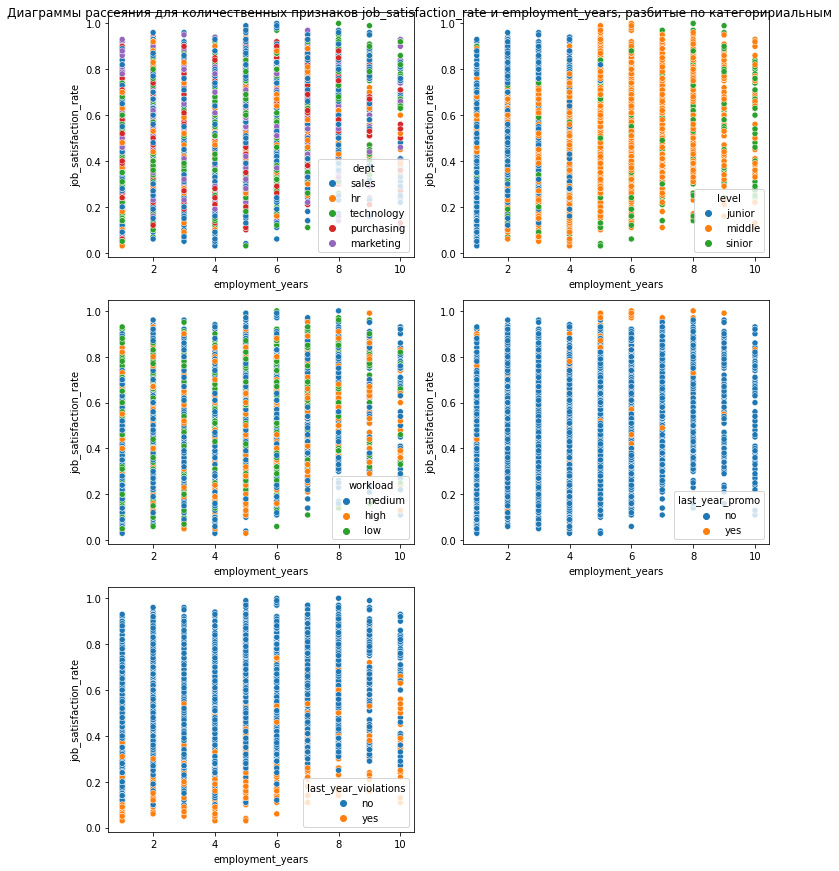

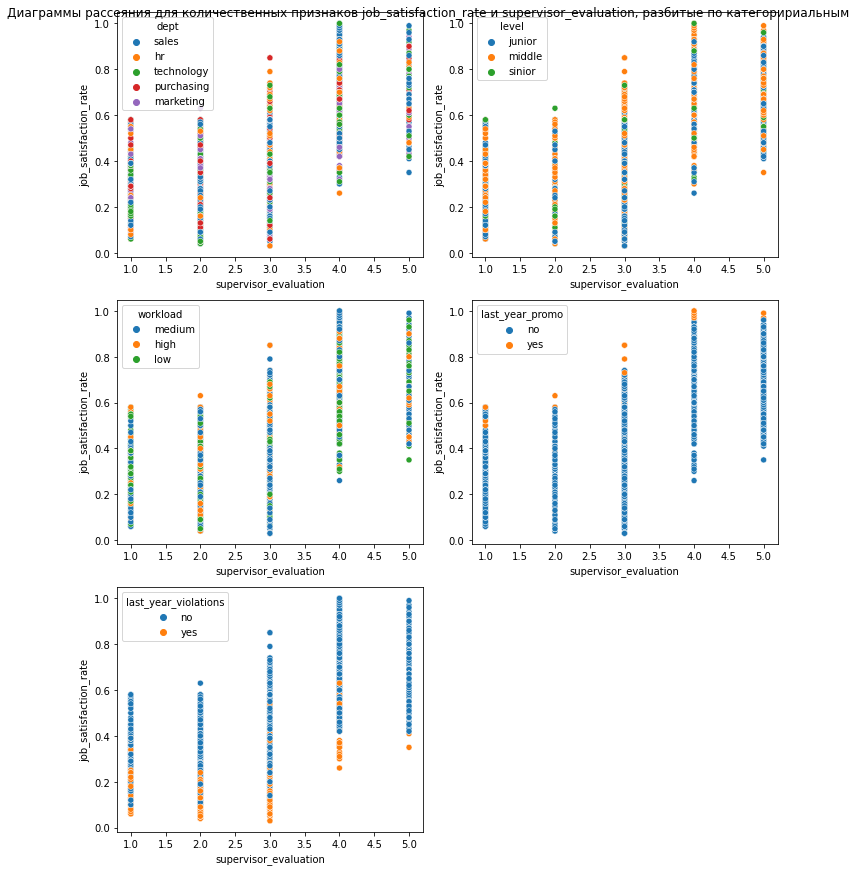

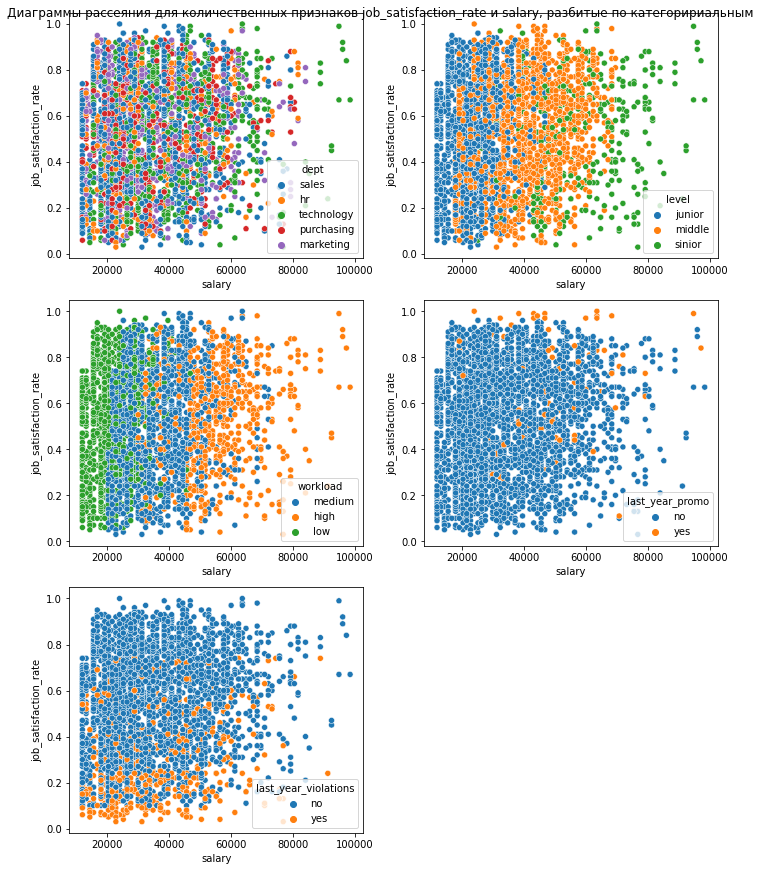

In [27]:
for quan in quan_columns:
    scatter_diagrams(train_sat, quan, 'job_satisfaction_rate', cat_columns)

In [28]:
train_sat.phik_matrix(['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']).round(3)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000,0.000,0.018,0.026,0.000,0.000,0.101,0.270,0.075
level,0.000,1.000,0.404,0.675,0.100,0.000,0.000,0.714,0.077
workload,0.018,0.404,1.000,0.166,0.058,0.000,0.038,0.785,0.044
employment_years,0.026,0.675,0.166,1.000,0.181,0.044,0.000,0.470,0.319
last_year_promo,0.000,0.100,0.058,0.181,1.000,0.011,0.016,0.211,0.191
last_year_violations,0.000,0.000,0.000,0.044,0.011,1.000,0.183,0.000,0.567
supervisor_evaluation,0.101,0.000,0.038,0.000,0.016,0.183,1.000,0.000,0.763
salary,0.270,0.714,0.785,0.470,0.211,0.000,0.000,1.000,0.150
job_satisfaction_rate,0.075,0.077,0.044,0.319,0.191,0.567,0.763,0.150,1.000


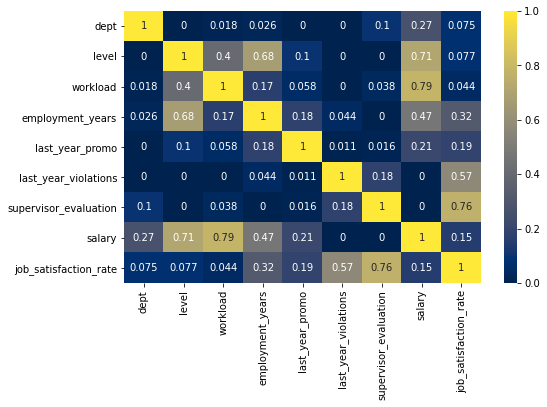

In [29]:
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(train_sat.phik_matrix(['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']).round(3), annot=True, cmap='cividis')
plt.show()

- Очень высоких корреляций не видно, скорее всего мультиколлинеарности нет
- Весомые корреляции между
    - зарплатойью уровнем занимаемой должности
    - зарплатой и уровнем нагрузки
    - уровнем занимаемой должности и стажем
    - таргетом и оценкой качества работы сотрудникаущий

Анализ данных для test_features

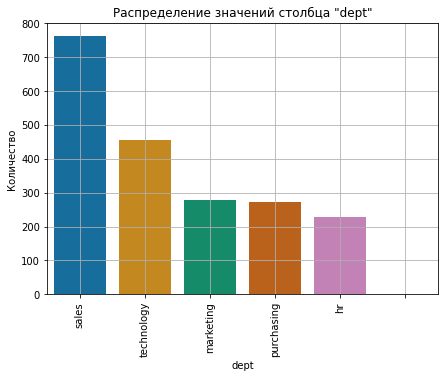

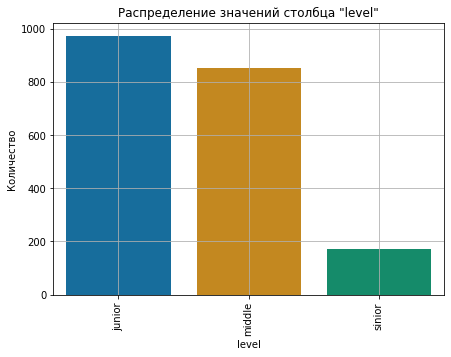

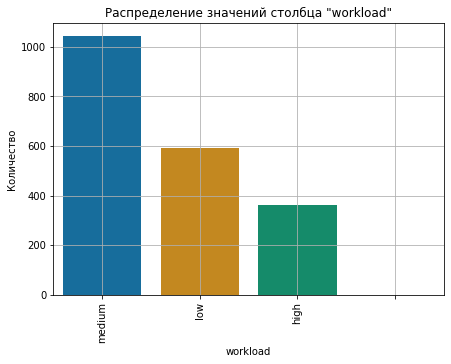

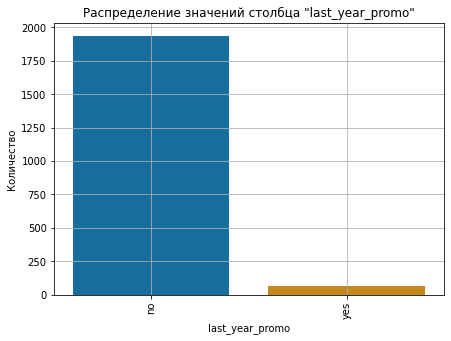

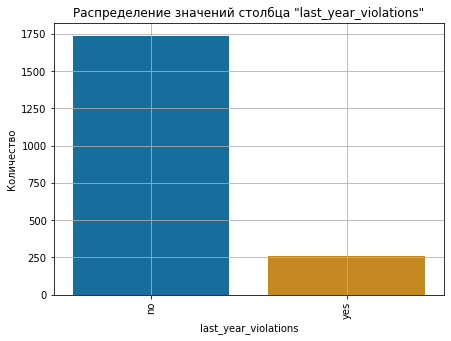

In [30]:
#Построим распредленеия качественных признаков для train_sat
for col in cat_columns:
    fig, ax = plt.subplots(figsize=(7,5))
    value_counts = test_features[col].value_counts()
    sns.countplot(x=col, data=test_features, palette='colorblind', order=value_counts.index)
    #plt.xticks(rotation=90)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90) 
    ax.set_xlabel(col)
    ax.set_ylabel('Количество')
    ax.set_title(f'Распределение значений столбца "{col}"')
    ax.grid(True)

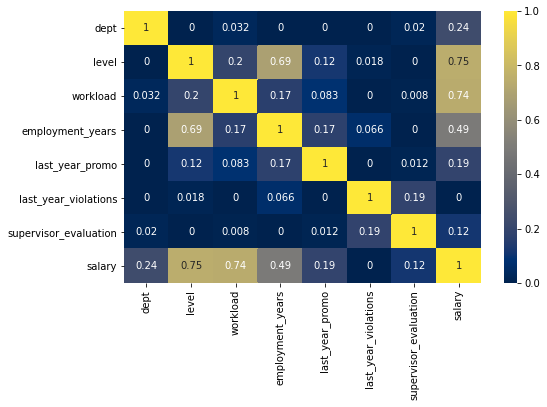

In [31]:
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(test_features.phik_matrix(['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']).round(3), annot=True, cmap='cividis')
plt.show()

В вообщем и целом тренировочные и тестовые данные имеют одинаковую структуру данных.

Был проведен исследовательский анализ всех данных из каждой таблицы, были построены графики распределениний, и исследованы корреляции между признаками.

### Шаг 4. Подготовка данных

In [32]:
#Создадим новый датафрейм для теста
test_data = pd.merge(test_features, test_sat, on='id', how='outer')
test_data.shape

(2000, 9)

In [33]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ore_columns = ['level', 'workload']

In [34]:
X_train = train_sat.drop('job_satisfaction_rate', axis=1)
y_train = train_sat['job_satisfaction_rate']

In [35]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

In [36]:
ore_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior', 'nan'], 
                    ['low', 'medium', 'high', 'nan'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [37]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ore', ore_pipe, ore_columns),
        ('num', StandardScaler(), quan_columns)
    ], 
    remainder='passthrough'
) 

In [38]:
#Итоговый пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

### Шаг 5. Обучение моделей

In [39]:
def smape(y, y_pred):
    ''' Вычисление SMAPE '''
    return 100/len(y) * np.sum(2 * np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred)))

smape_score = make_scorer(smape, greater_is_better=False)

Поменяем набор значений гиперпараметров, так чтобы max_depth мог быть не фиксированным</b></span>

In [40]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth' : [3, 5, 7, None],
        'models__max_features' : range(2, 15),
        'models__min_samples_split' : range(2, 10),
        'models__min_samples_leaf': range(1, 10),
        'preprocessor__num' : [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_score,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ore',
                            

Выведем результаты оценки каждой модели</b></span>

In [41]:
randomized_search.cv_results_

{'mean_fit_time': array([0.02792988, 0.01856184, 0.01857467, 0.01982503, 0.01850524,
        0.01959376, 0.01800742, 0.01974149, 0.01997209, 0.02188749]),
 'std_fit_time': array([1.45278005e-02, 1.30354669e-03, 8.33474517e-04, 1.24082649e-04,
        1.68829824e-04, 8.79639529e-04, 8.78945023e-05, 3.14543325e-04,
        1.64911703e-04, 1.27304492e-03]),
 'mean_score_time': array([0.00846024, 0.00770602, 0.00687361, 0.00770812, 0.00771976,
        0.00776858, 0.00760059, 0.00773969, 0.00836802, 0.00744629]),
 'std_score_time': array([1.11232693e-03, 1.12433103e-03, 5.35403412e-05, 9.43816496e-05,
        8.41116959e-05, 9.43617726e-05, 3.08360677e-05, 9.64039975e-05,
        8.52533540e-04, 5.95851485e-04]),
 'param_preprocessor__num': masked_array(data=[MinMaxScaler(), 'passthrough', 'passthrough',
                    MinMaxScaler(), MinMaxScaler(), MinMaxScaler(),
                    MinMaxScaler(), MinMaxScaler(), MinMaxScaler(),
                    'passthrough'],
              mas

In [42]:
model = randomized_search.best_estimator_.named_steps['models']
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']

#X_train_new = preprocessor.transform(X_train)
#X_test_new = preprocessor.transform(test_data.drop('job_satisfaction_rate', axis=1))

#y_pred = model.predict(X_test_new)
y_pred = randomized_search.predict(test_data.drop('job_satisfaction_rate', axis=1))

In [43]:
y_test_arr = (np.array(test_data['job_satisfaction_rate'])).ravel()
y_test_arr

array([0.79, 0.72, 0.64, ..., 0.11, 0.43, 0.67])

In [44]:
smape(y_test_arr, y_pred)

13.477380239390591

### Шаг 6. Оформление выводов

Лучшей моделью стала DecisionTreeRegressor с гиперпараметрами  max_features=14,  min_samples_leaf=4, min_samples_split=9 без кодировки количественных признаков. Метрика SMAPE на тестовых данных равна 13.5, что является удовлетворительным результатом. Деревья решений хорошо подходят для моделирования нелинейных зависимостей в данных, эта модель улавливает сложные нелинейные закономерности, поэтому лучшей моделью для нашей задачи стала именно DecisionTreeRegressor.

## Задача 2: Предсказание увольнения сотрудника из компании

### Шаг 1. Загрузка данных

In [48]:
train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
test_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

In [49]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [50]:
test_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [51]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [52]:
test_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Данные соотвествуют описанию задачи: к тренировочным данным добавлен новый столбец - увольнение. Размер тренировочной выборки - 4000, тестовой- 2000. Все названия столбоцов корректны и соответсвуют змеиному регистру.

### Шаг 2. Предобработка данных

In [53]:
#Переведем столбец id в индекс
train_quit = train_quit.set_index('id')
test_quit = test_quit.set_index('id')


In [54]:
#Проверим наличие пропусков в данных
print(f'Пропусков в train_quit: {train_quit.isnull().sum()}')
print()
print(f'Пропусков в test_quit: {test_quit.isnull().sum()}')
print()

Пропусков в train_quit: dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Пропусков в test_quit: quit    0
dtype: int64



In [55]:
#Уникальные значения столбца quit
train_quit['quit'].unique()

array(['no', 'yes'], dtype=object)

In [56]:
test_quit['quit'].unique()

array(['yes', 'no'], dtype=object)

### Шаг 3. Исследовательский анализ данных

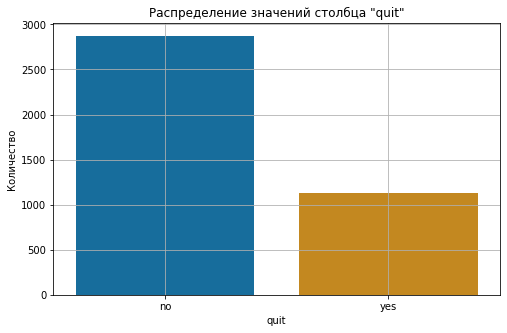

In [57]:
#Распределение целевого признакака в тренировочной выборке
fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(x='quit', data=train_quit, palette='colorblind')
ax.set_xlabel('quit')
ax.set_ylabel('Количество')
ax.set_title(f'Распределение значений столбца "quit"')
ax.grid(True)

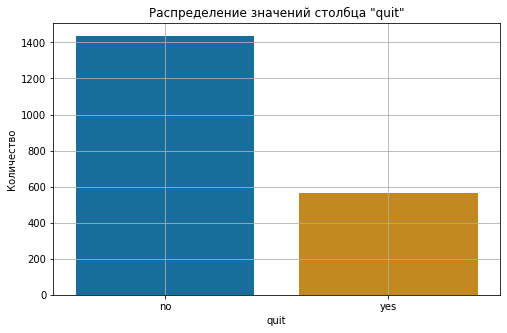

In [58]:
#Распределение целевого признакака в тестовой выборке
fig, ax = plt.subplots(figsize=(8,5))
value_counts = test_quit['quit'].value_counts()
sns.countplot(x='quit', data=test_quit, palette='colorblind', order=value_counts.index)
ax.set_xlabel('quit')
ax.set_ylabel('Количество')
ax.set_title(f'Распределение значений столбца "quit"')
ax.grid(True)

Явный дисбаланс целевого признака: уволенных сотрудников намного меньше. Распределения целевого призенакак одинакого для тренировочной и тестовой выборок.

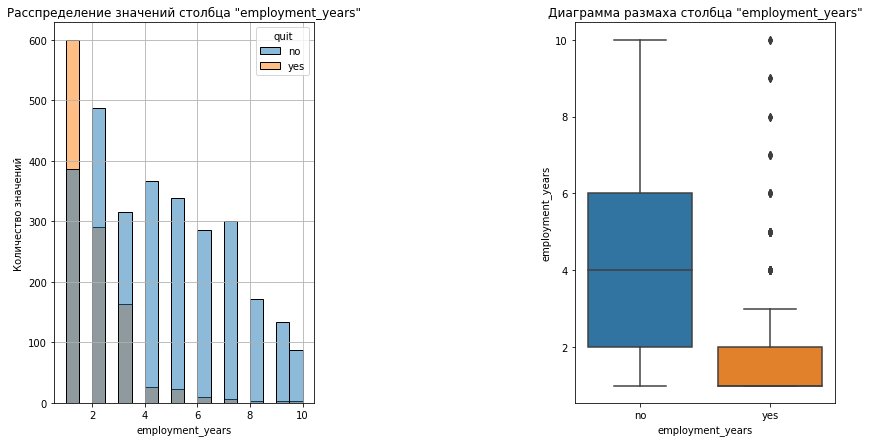

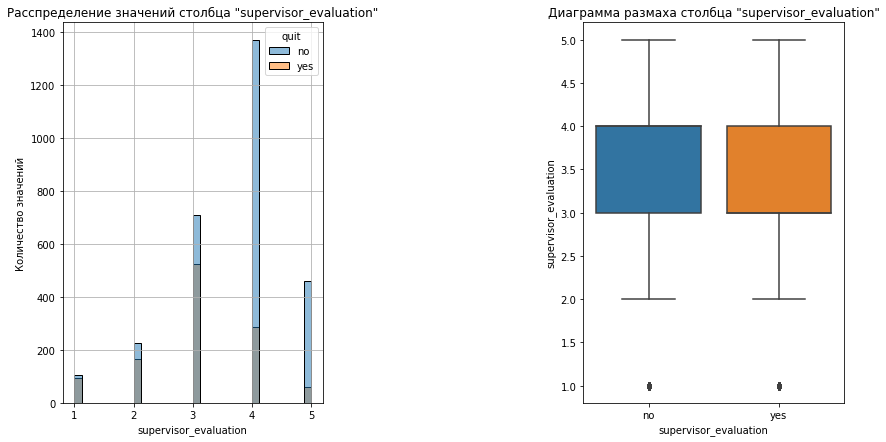

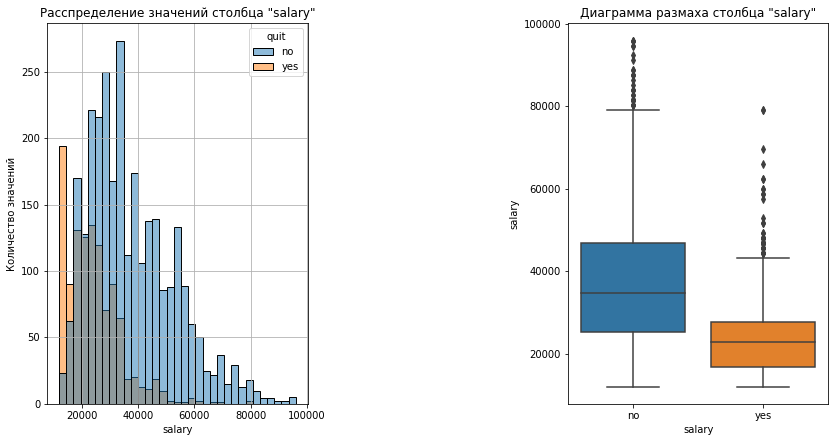

In [59]:
#Постороим распределения количественных признаков для train_quit
for col in quan_columns:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
    sns.histplot(data=train_quit, x=col, hue='quit', ax=ax[0])
    ax[0].set_title(f'Расспределение значений столбца "{col}"')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('Количество значений')
    ax[0].grid(True)
    
    sns.boxplot(data=train_quit, x='quit', y=col, ax=ax[1])
    ax[1].set_title(f'Диаграмма размаха столбца "{col}"')
    ax[1].set_xlabel(col)
    
    plt.subplots_adjust(wspace=1, hspace=1)

</span><br><span style="color: purple"><b>Нормализуем данные</b></span>

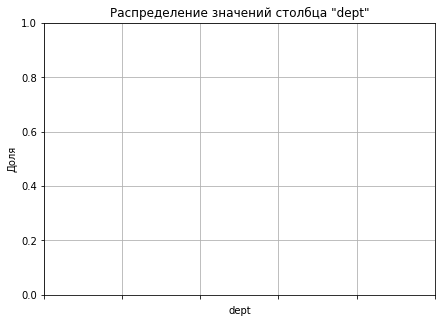

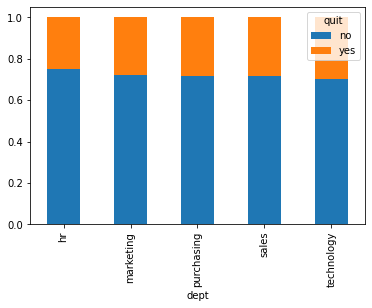

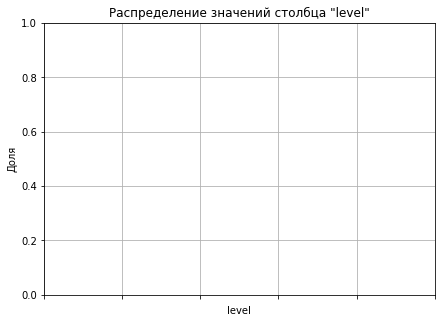

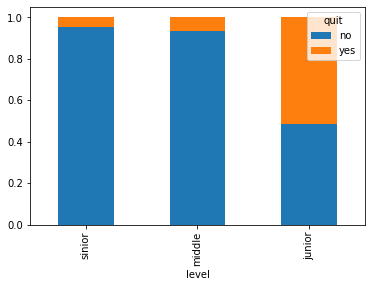

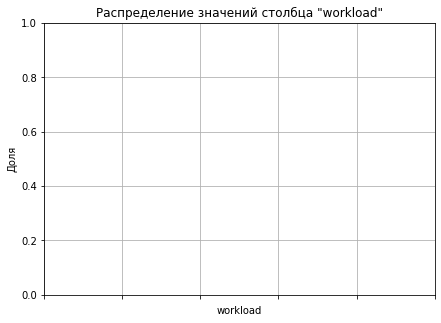

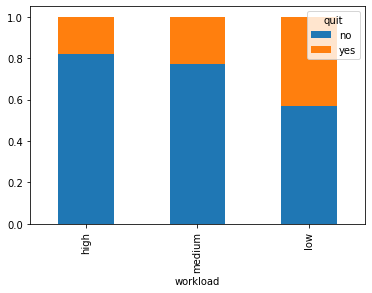

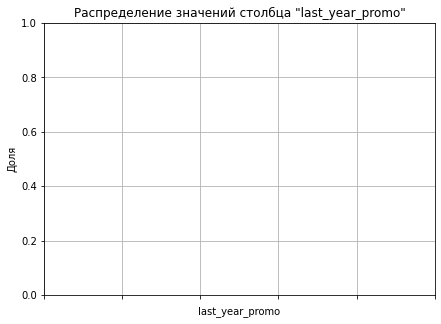

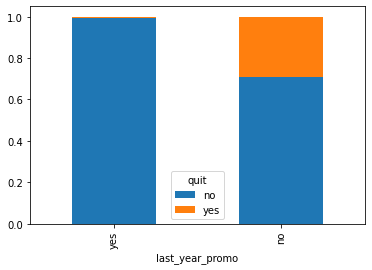

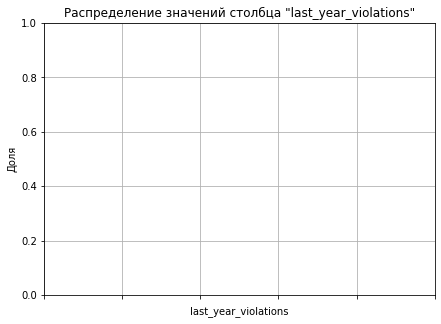

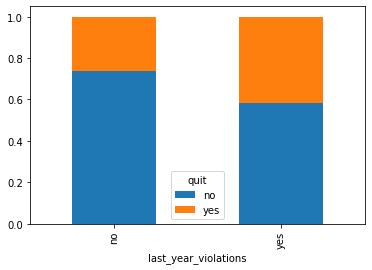

In [60]:
#Построим распредленеия качественных признаков для train_quit разбытых по целевому признаку

for col in cat_columns:
    data_quit = train_quit.groupby(col)['quit'].value_counts(normalize=True).unstack()
    data_quit_sorted = data_quit.sort_values('no', ascending=False)
    
    fig, ax = plt.subplots(figsize=(7,5))
    data_quit_sorted.plot(kind='bar', stacked=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90) 
    ax.set_xlabel(col)
    ax.set_ylabel('Доля')
    ax.set_title(f'Распределение значений столбца "{col}"')
    ax.grid(True)

Построим портерет уволившегося сотрудника:
- он работал в отделе продаж
- на занимаемой должности junior
- с маленьким уровнем загруженности
- без повышения в должности за последний год
- с некоторым количеством нарушений трудового договора за последний год
- с маленьким стажем работы
- с оценкой качества работы сотрудника, которую дал руководитель - 3
- с зарплатой около 15000

Визуализируем и сравним распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. 

In [61]:
test_features = pd.merge(test_features, test_sat, on='id', how='outer')
data = pd.merge(test_features, test_quit, on='id', how='outer')
data.sample(1)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
185858,marketing,junior,medium,1,no,no,4,31200,0.71,no


</span><br><span style="color: purple"><b>Нормализуем данные по плотности</b></span>

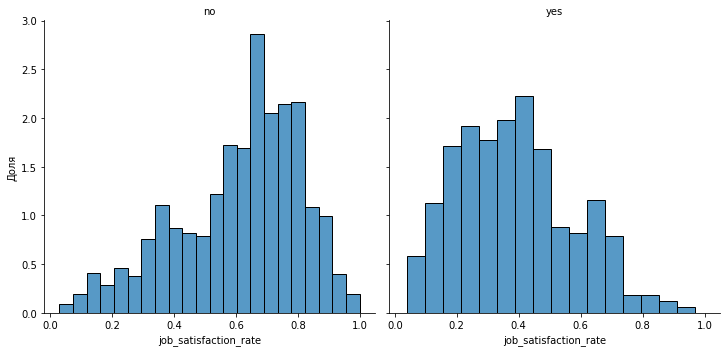

In [62]:
#Построим графики распределений job_satisfaction_rate разбитыъ по quit
graph = sns.FacetGrid(data=data, col='quit', height= 5)

graph.map(sns.histplot, 'job_satisfaction_rate', stat='density', common_norm=False)

graph.set_titles(col_template='{col_name}')
graph.set_axis_labels('job_satisfaction_rate', 'Доля')
plt.show()

Распределения удовлетворённости сотрудника работой разные для сотрудников, которые уволились и нет. Следовательно между двумя этими признаками есть взаимное влияние.

### Шаг 4. Добавление нового входного признака

In [63]:
train_quit_new = preprocessor.transform(train_quit.drop('quit', axis=1))
job_satisfaction_rate = model.predict(train_quit_new)
train_quit['job_satisfaction_rate'] = job_satisfaction_rate

train_quit

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.605000
814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.332500
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.350000
910140,marketing,junior,medium,2,no,no,5,25200,no,0.791667
...,...,...,...,...,...,...,...,...,...,...
588809,sales,junior,medium,4,no,no,3,26400,no,0.518889
672059,sales,middle,high,9,no,no,4,52800,no,0.836000
536432,purchasing,junior,low,2,no,yes,4,12000,yes,0.544286


### Шаг 5. Подготовка данных

</span><br><span style="color: purple"><b>Добавим job_satisfaction_rate как предсказание первой модели</b></span>

In [64]:
#Создадим новый датафрейм, чтобы id в тестах были соответствующие
job_satisfaction_rate_test = randomized_search.predict(test_features.drop('job_satisfaction_rate', axis=1))

test_features_data = pd.merge(test_features, test_quit, on='id', how='outer')
test_features_data['job_satisfaction_rate'] = job_satisfaction_rate_test
test_features_data.shape

(2000, 10)

</span><br><span style="color: purple"><b>Кодируем тестовые данные целевого признака</b></span>

In [65]:
#Закодируем целевой признак в train_quit и test_quit
y = train_quit['quit']
label_mapping = {'yes': 1, 'no': 0}
le = LabelEncoder()
y = le.fit_transform(y.map(label_mapping))

y_test_quit = le.transform(test_features_data['quit'].map(label_mapping))

X_train_quit = train_quit.drop('quit', axis=1)

In [66]:
#Создаем список с количественными признаками
num_columns = train_quit.select_dtypes(['int', 'float']).columns.tolist()
num_columns

['employment_years',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

In [67]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ore', ore_pipe, ore_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### Шаг 6. Обучение модели

In [68]:
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid=[

    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 12),
        'models__min_samples_split' : range(2, 10),
        'models__min_samples_leaf': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    
     
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },

    
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__kernel': ['linear', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

search.fit(X_train_quit, y)

print('Лучшая модель и её параметры:\n\n', search.best_estimator_)
print ('Метрика лучшей модели:', search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ore',
                            

In [69]:
search.cv_results_

{'mean_fit_time': array([0.0237597 , 0.01882534, 0.02026892, 0.02030578, 0.02205181,
        0.01955891, 0.02255983, 0.01854095, 0.01903253, 0.02397032]),
 'std_fit_time': array([0.00173843, 0.00018844, 0.00011637, 0.00012031, 0.00040633,
        0.00023729, 0.00048625, 0.00014772, 0.00028545, 0.00257262]),
 'mean_score_time': array([0.00902295, 0.00845551, 0.00839934, 0.00857048, 0.00850492,
        0.00848317, 0.00846009, 0.00842576, 0.00864887, 0.00877471]),
 'std_score_time': array([6.49118110e-04, 1.40951644e-04, 1.58253913e-05, 7.77898700e-05,
        4.87243585e-05, 7.24571282e-05, 1.02821329e-04, 5.42705629e-05,
        2.54364133e-04, 1.88118840e-04]),
 'param_preprocessor__num': masked_array(data=[MinMaxScaler(), StandardScaler(), StandardScaler(),
                    StandardScaler(), StandardScaler(), MinMaxScaler(),
                    StandardScaler(), StandardScaler(), MinMaxScaler(),
                    MinMaxScaler()],
              mask=[False, False, False, False, Fa

In [70]:
model_quit = search.best_estimator_.named_steps['models']
preprocessor = search.best_estimator_.named_steps['preprocessor']

X_test_new = preprocessor.transform(test_features_data.drop('quit', axis=1))

probas = model_quit.predict_proba(X_test_new)
score = roc_auc_score(y_test_quit, probas[:,1])
score

0.9190243535036252

Проанализируем важность входных признаков

In [71]:
X_train_new = preprocessor.transform(X_train_quit)

#Получим названия признаков
feature_names = preprocessor.get_feature_names_out()

#Создадим тоблицу с обработанными данными для sharp
sharp_df = pd.DataFrame(X_train_new, columns=feature_names).sample(100, random_state=RANDOM_STATE)

explainer = shap.Explainer(model_quit.predict, sharp_df)
shap_values = explainer(sharp_df)


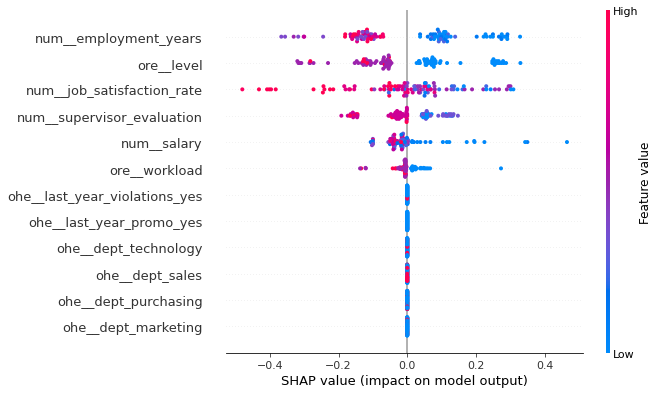

In [72]:
#Визуализируем вклад признаков в предсказание модели
shap.plots.beeswarm(shap_values, max_display=20)

In [73]:
#Пострим грфик shap.plots.bar через plt.bar
#построим таблицу с shap_values
df = pd.DataFrame(shap_values.values, columns=feature_names)

#возьмем модули значений shap_values
df = df.abs()
#создадим новую табличку со средними значениями shap_value
df_mean = df.mean().reset_index()
df_mean.columns = ['признак', 'shap_value']
df_mean = df_mean.sort_values(by='shap_value')
df_mean.head()

,признак,shap_value
0,ohe__dept_marketing,0.0
1,ohe__dept_purchasing,0.0
2,ohe__dept_sales,0.0
3,ohe__dept_technology,0.0
4,ohe__last_year_promo_yes,0.0


<BarContainer object of 12 artists>

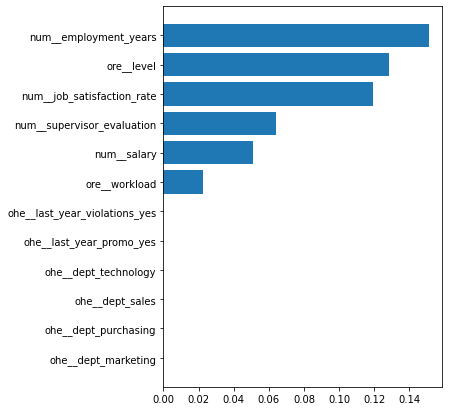

In [74]:
plt.subplots(figsize=(5,7))
plt.barh(df_mean['признак'], df_mean['shap_value'])


Мало значимы для модели признак
- отдел работы
- повышение
- нарушения
- оценка качества работы, данная руководителемесяца   

Самые весомые п
- уровень удовлетворенности сотрудником
- уровень занимаемой должности
- стаж работы в компанииые продукты


Попробуем улучшить качетсво нашей модели убрав малозначимые признаки

In [75]:
columns_to_drop = ['dept','last_year_promo','last_year_violations']

# удалим признаки
X_train_quit = X_train_quit.drop(columns_to_drop, axis=1)
test_features_data =  test_features_data.drop(columns_to_drop, axis=1)

In [76]:
data_preprocessor = ColumnTransformer(
    [
        ('ore', ore_pipe, ore_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models',DecisionTreeClassifier(max_depth=9, 
                               max_features=10,
                               min_samples_leaf=9,
                               min_samples_split=3,
                               random_state=RANDOM_STATE))
    ]
)


pipe_final.fit(X_train_quit, y)

#probas = pipe_final.predict_proba(X_test_new)

y_test_pred = pipe_final.predict_proba(test_features_data.drop('quit', axis=1))
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_quit, y_test_pred[:,1])}') 

Метрика ROC-AUC на тестовой выборке: 0.920484403089749


Добиться улучшения качества модели за счет удаления ненужных признаков удалось

### Шаг 7. Выводы

Лучшей моделью стала DecisionTreeClassifier с гиперпараметрами max_depth=5, max_features=9, min_samples_leaf=4, min_samples_split=9 с кодировкой количественных признаков MinMaxScaler(). Метрика roc_auc_score на тестовых данных равна 0.92, что является удовлетворительным результатом. Деревья решений хорошо подходят для моделирования нелинейных зависимостей в данных, эта модель улавливает сложные нелинейные закономерности, поэтому лучшей моделью для нашей задачи стала именно DecisionTreeClassifier.

## Общий вывод

В ходе проектной работы была разработана модель, которая позволит быстрее и точнее отвечать на вопросы бизнеса, а именно предсказывать уровень удовлетворённости сотрудника работой и отток сотрудников. 

Проект разделен на две части: предсказание уровня удовлетворённости сотрудника и предсказание увольнения сотрудника из компании.

Первым шагом в обоих частях была загрузка данных: были считаны csv-файлы с данными, при помощи библиотеки pandas, они были сохранены в датафреймы. Далее были выведены первые строки наборов данных, была изучена общая информация о датафреймах.

Во втором шаге проводилась предобработка данных: были проверены данные на наличие пропусков и дубликатов. Пропуски будут заполнены автоматически в пайплайне.

В третьем шаге проводился исследовательский анализ данных: был проведен статистический анализ всех признаков.
Были построены графики для каждого признак по отдельности. Также были построены диаграммы рассеяния количественных признаков, разбитых по категориальным признакам. Был проведен корреляционный анализ: визуализированы зависимости между признаками.

Далее во втрой части проекта был добавлен новый входной признак - степень удовлетворённости сотрудника работой. Он был взят из результатов работы модели первой части.

Следущим шагом была подготовка данных: признаки были подготовлены в пайплайне, были заполнены пропуски в данных, закодированы категориальные признаки и отмасштабированы количественные признаки.

Последним шагом стало обучение моделей: были построен итоговый пайплайн, с помощью которого была определена лучшая модель с опредленными гиперпарамет рами: в первой задаче ей стала - DecisionTreeRegressor с гиперпараметрами max_depth=9, max_features=12, min_samples_leaf=7 без кодировки количественных признаков, во втрой задаче - DecisionTreeClassifier с гиперпараметрами max_depth=5, max_features=9, min_samples_leaf=4, min_samples_split=9 с кодировкой количественных признаков MinMaxScaler(). Лучше всего себя показала именно дерево решений, т.к в наших задачах преобладают сложные нелинейные зависимости, с которыми данная модель хорошо справляется..